In [ ]:
!gdown 1ZUCuYDOe4VVbZvNVZovpquaRQqqJQ639 -O "data/scenes_classification.zip"
!unzip data/scenes_classification.zip -d data
!rm data/scenes_classification.zip

In [3]:
import torch
import torch.nn as nn
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Setting Random Seed for Reproducibility

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 59
set_seed(seed)

## Data Preparation

In [6]:
root_dir = "data/scenes_classification"
train_dir = os.path.join(root_dir, "train")
test_dir = os.path.join(root_dir, "val")

# Mapping class names to numeric labels
classes = {
    label_idx: class_name for label_idx, class_name in enumerate(sorted(os.listdir(train_dir)))
}

Loading image paths and labels

In [10]:
X_train, y_train = [], []
X_test, y_test = [], []

for dataset_path in [train_dir, test_dir]:
    for label_idx, class_name in classes.items():
        class_dir = os.path.join(dataset_path, class_name)
        for img_filename in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_filename)
            if "train" in dataset_path:
                X_train.append(img_path)
                y_train.append(label_idx)
            else:
                X_test.append(img_path)
                y_test.append(label_idx)

len(X_train), len(X_test)

(14034, 3000)

In [11]:
X_train[:5], y_train[:5]

(['scenes_classification/train/buildings/14704.jpg',
  'scenes_classification/train/buildings/17575.jpg',
  'scenes_classification/train/buildings/1964.jpg',
  'scenes_classification/train/buildings/12716.jpg',
  'scenes_classification/train/buildings/4961.jpg'],
 [0, 0, 0, 0, 0])

Splitting the training data into training and validation sets

In [13]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=True,
    shuffle=True
)

len(X_train), len(X_val)

(8981, 2246)

Defining a custom ScenesDataset class for loading images with transformations

In [22]:
class ScenesDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.img_paths = X
        self.labels = y
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

In [23]:
def transform(img, img_size=(224, 224)):
    img = img.resize(img_size)
    # Convert the image to a NumPy array and select the RGB channels (first 3 channels)
    img = np.array(img)[..., :3]
    
    # Convert the image to a PyTorch tensor and change the shape to (channels, height, width)
    img = torch.tensor(img).permute(2, 0, 1).float()
    
    # Normalize the image by dividing pixel values by 255, scaling them to the range [0, 1]
    normalized_img = img / 255.0
    return normalized_img

In [24]:
train_dataset = ScenesDataset(
    X_train, y_train,
    transform=transform
)

val_dataset = ScenesDataset(
    X_val, y_val,
    transform=transform
)

test_dataset = ScenesDataset(
    X_test, y_test,
    transform=transform
)

Creating DataLoaders for training, validation, and test sets

In [26]:
train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

len(train_loader), len(val_loader), len(test_loader)

(141, 281, 375)

## DenseNet Training and Evaluation

### Training and Evaluation Functions for Model

In [39]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    correct, total = 0, 0
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            # Calculate predictions
            _, preds = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    # Calculate average loss and accuracy
    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc

In [40]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        correct, total = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() # Backpropagation
            optimizer.step() # Update weights

            batch_train_losses.append(loss.item())

            _, preds = torch.max(outputs.data, dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        # Calculate average training loss for the epoch
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validate the model
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch + 1}/{epochs}:\t"
            f"Train Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}\t"
            f"Val Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}"
        )

    return train_losses, train_accuracies, val_losses, val_accuracies

### DenseNet Model Implementation

In [36]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(BottleneckBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(4 * growth_rate)
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        res = x.clone().detach()
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = torch.cat([res, x], 1)

        return x

class DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        layers = []
        for i in range(num_layers):
            layers.append(BottleneckBlock(in_channels + i * growth_rate, growth_rate))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

In [37]:
class DenseNet(nn.Module):
    def __init__(self, num_blocks, growth_rate, num_classes):
        super(DenseNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 2 * growth_rate, kernel_size=7, padding=3, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(2 * growth_rate)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Initialize DenseBlocks
        self.dense_blocks = nn.ModuleList()
        in_channels = 2 * growth_rate
        for i, num_layers in enumerate(num_blocks):
            self.dense_blocks.append(
                DenseBlock(num_layers, in_channels, growth_rate)
            )
            in_channels += num_layers * growth_rate
            if i != len(num_blocks) - 1:
                out_channels = in_channels // 2
                self.dense_blocks.append(
                    nn.Sequential(
                        nn.BatchNorm2d(in_channels),
                        nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                        nn.AvgPool2d(kernel_size=2, stride=2)
                    )
                )
                in_channels = out_channels

        self.bn2 = nn.BatchNorm2d(in_channels)
        self.pool2 = nn.AvgPool2d(kernel_size=7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool1(x)

        for block in self.dense_blocks:
            x = block(x)

        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

### Training model

In [38]:
n_classes = len(list(classes.keys()))
device = "cuda" if torch.cuda.is_available() else "cpu"

model = DenseNet(
    [6, 12, 24, 16],
    growth_rate=32,
    num_classes=n_classes
).to(device)

In [41]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

train_losses, train_accuracies, val_losses, val_accuracies = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=15
)

Epoch 1/15:	Train Loss: 1.4976	Train Acc: 0.4520	Val Loss: 1.3401	Val Acc: 0.4426
Epoch 2/15:	Train Loss: 1.2644	Train Acc: 0.5469	Val Loss: 1.2045	Val Acc: 0.5592
Epoch 3/15:	Train Loss: 1.1778	Train Acc: 0.5790	Val Loss: 1.1314	Val Acc: 0.5935
Epoch 4/15:	Train Loss: 1.1247	Train Acc: 0.5968	Val Loss: 1.0918	Val Acc: 0.6073
Epoch 5/15:	Train Loss: 1.0844	Train Acc: 0.6102	Val Loss: 1.0523	Val Acc: 0.6109
Epoch 6/15:	Train Loss: 1.0444	Train Acc: 0.6239	Val Loss: 1.0253	Val Acc: 0.6175
Epoch 7/15:	Train Loss: 1.0097	Train Acc: 0.6342	Val Loss: 0.9825	Val Acc: 0.6402
Epoch 8/15:	Train Loss: 0.9735	Train Acc: 0.6480	Val Loss: 0.9598	Val Acc: 0.6532
Epoch 9/15:	Train Loss: 0.9373	Train Acc: 0.6680	Val Loss: 0.9182	Val Acc: 0.6652
Epoch 10/15:	Train Loss: 0.8994	Train Acc: 0.6837	Val Loss: 0.8879	Val Acc: 0.6687
Epoch 11/15:	Train Loss: 0.8632	Train Acc: 0.6932	Val Loss: 0.8604	Val Acc: 0.6794
Epoch 12/15:	Train Loss: 0.8355	Train Acc: 0.7067	Val Loss: 0.8366	Val Acc: 0.6932
Epoch 13/15:	

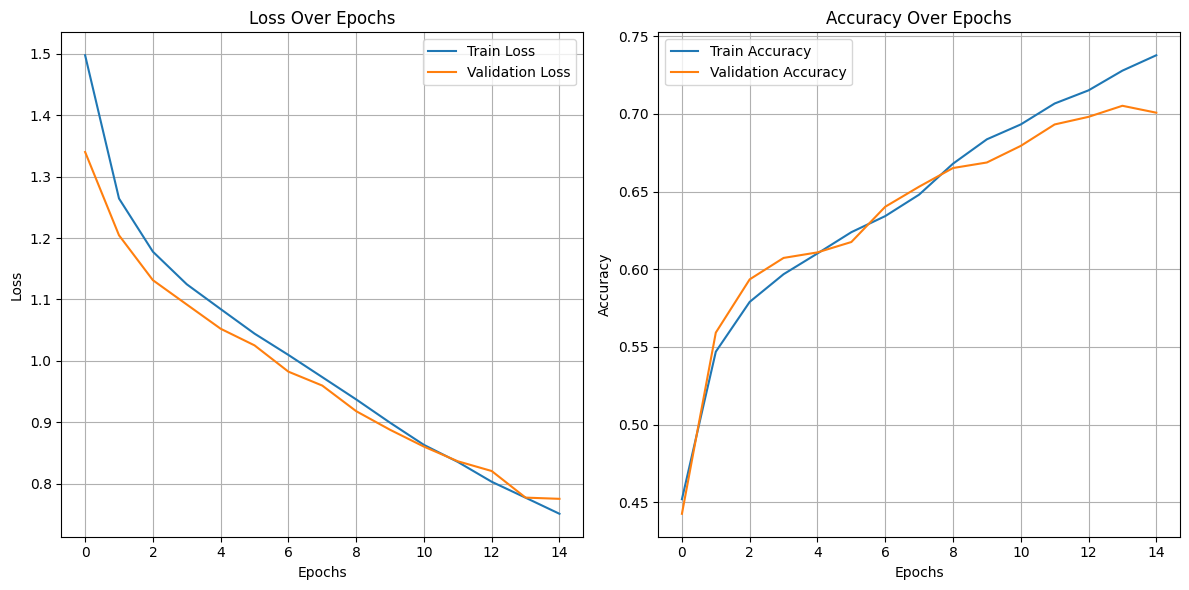

In [42]:
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### Evaluation model

In [43]:
val_loss, val_acc = evaluate(model, val_loader, criterion, device)
test_loss, test_acc = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset:")
print("Validation accuracy: ", val_acc)
print("Test accuracy: ", test_acc)

Evaluation on val/test dataset:
Validation accuracy:  0.7008014247551202
Test accuracy:  0.7186666666666667
